In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tarfile

from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, random_rotation, random_shear, random_shift, random_zoom
from tensorflow.keras.preprocessing import image_dataset_from_directory 

Mounted at /content/drive


In [ ]:
df = pd.read_csv("mnist.train.map.csv")
df[['category']].value_counts()

labels = np.unique(df['category'])

In [ ]:
## copyfile from aggregating folder to seperating folder by classes
def copy_file(src_fn, dst_fn, src_path, dst_path):
    
    shutil.copy(src_path/src_fn, dst_path/dst_fn)

for label in labels:
    os.makedirs('./tf-trainset/'+str(label), exist_ok = True)

for row in df.iterrows():
    label = row[1][1]
    filename = row[1][0]
    
    dst_path = Path('./tf-trainset')/str(label)
    src_path = Path('./train')
    
    shutil.copy(src_path/filename, dst_path/filename)

In [ ]:
df['category'].value_counts().sort_index()

0    1100
1    1048
2     966
3     910
4     809
5     790
6     718
7     691
8     611
9     612
Name: category, dtype: int64

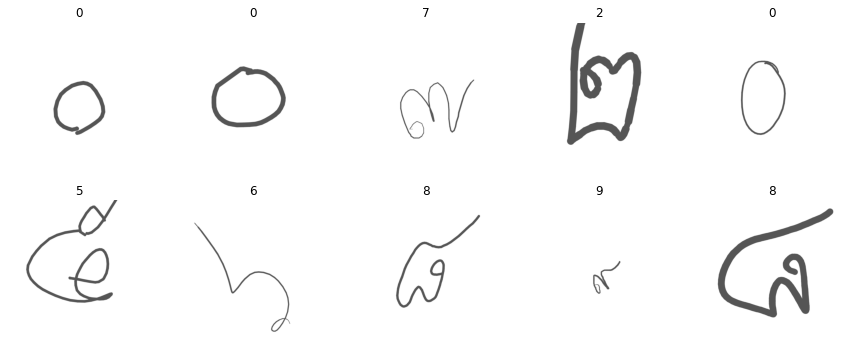

In [ ]:
# sample data to be plotted
sample_df = df.sample(10)
plt.figure(figsize=(5*3,2*3))

for ind, (sample_fn, cat) in enumerate(zip(sample_df['id'], sample_df['category'])):
    
    img = mpimg.imread(src_path/sample_fn)
    plt.subplot(2, 5, ind+1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis('Off')

# Train on uncropped Image. 
**Since, I have no drop list, so I will train on all of them!**

In [ ]:
# one channel for cropping
trainset = image_dataset_from_directory('./tf-trainset', color_mode='rgb', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='training', batch_size=32).cache().prefetch(2)

validset = image_dataset_from_directory('./tf-trainset', color_mode='rgb', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='validation', batch_size=32).cache().prefetch(2)


Found 8255 files belonging to 10 classes.
Using 7430 files for training.
Found 8255 files belonging to 10 classes.
Using 825 files for validation.


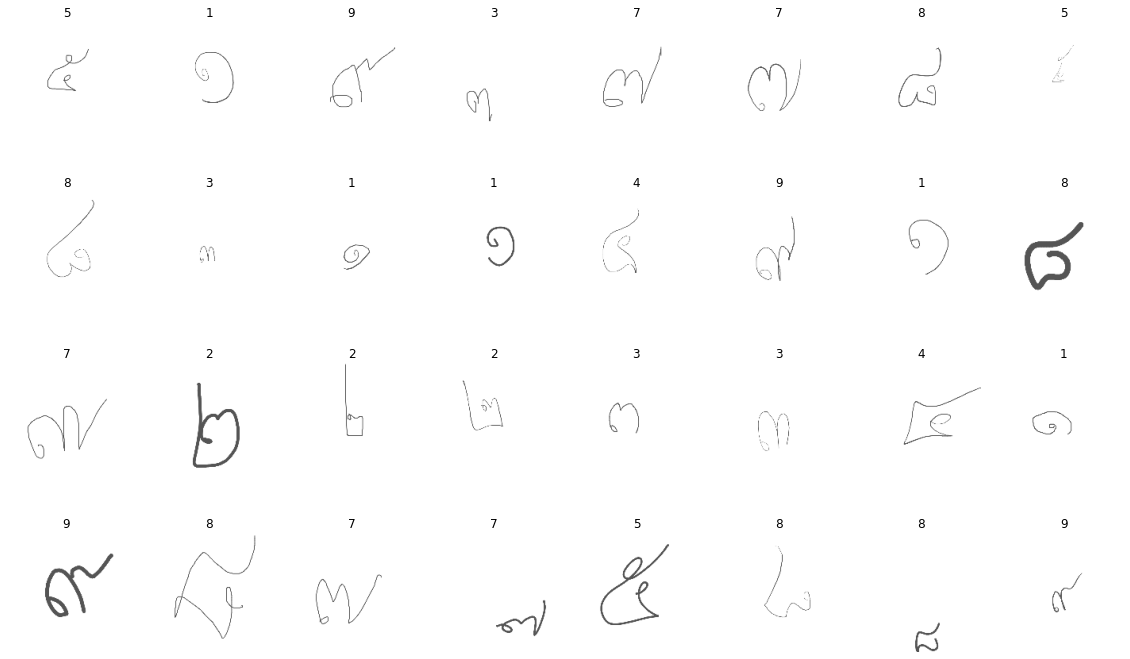

In [ ]:
imgs, labels = next(iter(trainset))

plt.figure(figsize=(10*2, 6*2))

for ind, img in enumerate(imgs):
    plt.subplot(4, 8, ind+1)
    plt.imshow(img/255.)
    plt.title(int(labels[ind]))
    plt.axis('Off')

## toy model

In [ ]:
## create basic keras model
keras.backend.clear_session()

inputs = keras.layers.Input(shape=(150, 150, 3))
outputs = inputs/255.
prep_input_model = keras.models.Model(inputs=inputs, outputs=outputs)

model = keras.Sequential([
    prep_input_model,
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
             optimizer='adam')

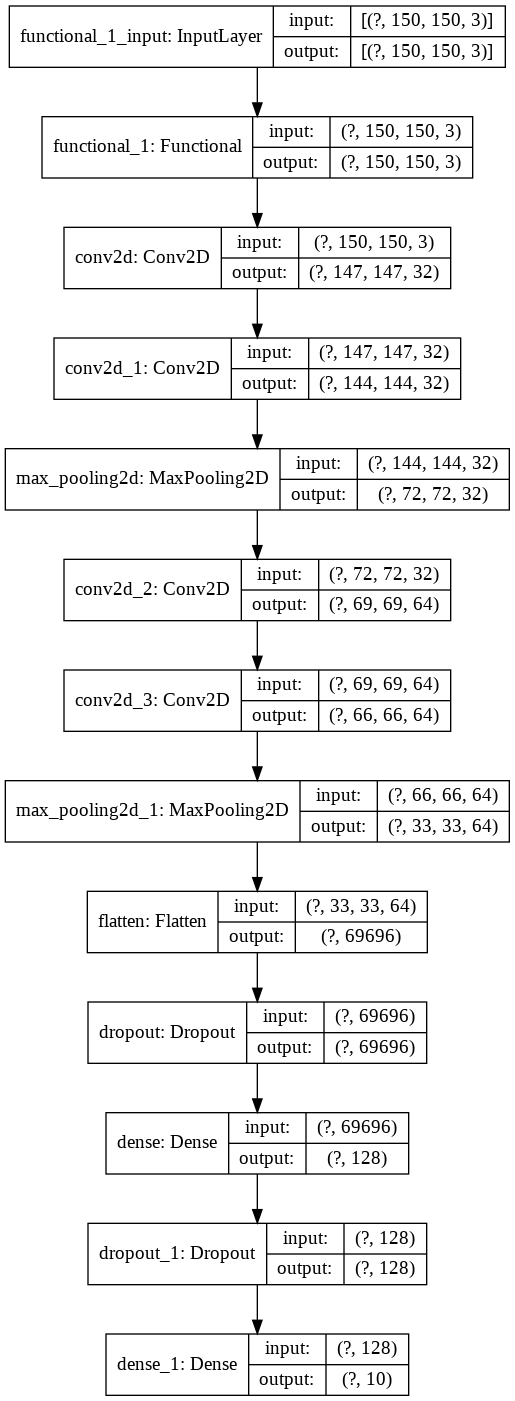

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 147, 147, 32)      1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 32)      16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 69, 69, 64)        32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 66, 66, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 64)        0

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model', monitor='val_acc', save_best_only=True)

In [ ]:
history = model.fit(trainset, epochs=20, validation_data=validset, callbacks=[cp_cb, early_cb])

Epoch 1/20
233/233 [==============================] - 71s 303ms/step - loss: 2.3021 - acc: 0.1281 - val_loss: 2.2852 - val_acc: 0.1338
Epoch 2/20
233/233 [==============================] - 69s 296ms/step - loss: 2.2858 - acc: 0.1355 - val_loss: 2.2830 - val_acc: 0.1338
Epoch 3/20
233/233 [==============================] - 69s 297ms/step - loss: 2.2886 - acc: 0.1288 - val_loss: 2.2851 - val_acc: 0.1338
Epoch 4/20
233/233 [==============================] - 69s 296ms/step - loss: 2.2838 - acc: 0.1302 - val_loss: 2.2868 - val_acc: 0.1265
Epoch 5/20
233/233 [==============================] - 69s 295ms/step - loss: 2.2836 - acc: 0.1279 - val_loss: 2.2827 - val_acc: 0.1338
Epoch 6/20
233/233 [==============================] - 69s 294ms/step - loss: 2.2832 - acc: 0.1329 - val_loss: 2.2826 - val_acc: 0.1338


## Transfer learning

In [ ]:
keras.backend.clear_session()

prep_input = keras.applications.xception.preprocess_input
giant_ml = keras.applications.xception.Xception(include_top=False)

In [ ]:
inputs = keras.layers.Input(shape=(150, 150, 3))
outputs = giant_ml(prep_input(inputs))
outputs = keras.layers.GlobalAveragePooling2D()(outputs)
outputs = keras.layers.Dropout(0.3)(outputs)
outputs = keras.layers.Dense(10)(outputs)

my_giant_ml = keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
my_giant_ml.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

### Warm gradient first

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model_giant_ml', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [ ]:
giant_ml.trainable=False
my_giant_ml.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              optimizer='adam')

history = my_giant_ml.fit(trainset, epochs=20, validation_data=validset, callbacks=[early_cb, cp_cb])

Epoch 1/20
233/233 [==============================] - 53s 226ms/step - loss: 1.2396 - sparse_categorical_accuracy: 0.6404 - val_loss: 0.8773 - val_sparse_categorical_accuracy: 0.7636
Epoch 2/20
233/233 [==============================] - 26s 111ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.7170 - val_sparse_categorical_accuracy: 0.7988
Epoch 3/20
233/233 [==============================] - 26s 110ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.8066 - val_loss: 0.6369 - val_sparse_categorical_accuracy: 0.8158
Epoch 4/20
233/233 [==============================] - 25s 107ms/step - loss: 0.6189 - sparse_categorical_accuracy: 0.8199 - val_loss: 0.5875 - val_sparse_categorical_accuracy: 0.8279
Epoch 5/20
233/233 [==============================] - 26s 111ms/step - loss: 0.5711 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.5552 - val_sparse_categorical_accuracy: 0.8315
Epoch 6/20
233/233 [==============================] - 26s 111ms/step - loss: 0.5340 -

### Train the whole giant model

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model_giant_ml', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [ ]:
giant_ml.trainable=True
my_giant_ml.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              optimizer='adam')

history = my_giant_ml.fit(trainset, epochs=50, validation_data=validset, callbacks=[early_cb, cp_cb])

Epoch 1/50
233/233 [==============================] - 62s 266ms/step - loss: 0.3554 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.2243 - val_sparse_categorical_accuracy: 0.9455
Epoch 2/50
233/233 [==============================] - 44s 187ms/step - loss: 0.1455 - sparse_categorical_accuracy: 0.9603 - val_loss: 0.4078 - val_sparse_categorical_accuracy: 0.8994
Epoch 3/50
233/233 [==============================] - 44s 187ms/step - loss: 0.0755 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.3514 - val_sparse_categorical_accuracy: 0.9248
Epoch 4/50
233/233 [==============================] - 44s 187ms/step - loss: 0.0992 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.2471 - val_sparse_categorical_accuracy: 0.9345
Epoch 5/50
233/233 [==============================] - 62s 264ms/step - loss: 0.0683 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.1437 - val_sparse_categorical_accuracy: 0.9624
Epoch 6/50
233/233 [==============================] - 44s 187ms/step - loss: 0.0652 -

## Error analysis

In [ ]:
my_giant_ml.evaluate(validset)

26/26 [==============================] - 1s 37ms/step - loss: 0.1306 - sparse_categorical_accuracy: 0.9794


[0.13063521683216095, 0.9793939590454102]

In [ ]:
x_test, y_test = next(iter(validset))
y_pred_test = tf.argmax(my_giant_ml.predict(x_test), axis=1, output_type=tf.int32)
count = 0
for x, y in validset.skip(1):
    if count == 25:
        break
    count += 1
    y_test = tf.concat([y_test, y], axis=0)
    y_pred = tf.argmax(my_giant_ml.predict(x), axis=1, output_type=tf.int32)
    y_pred_test = tf.concat([y_pred_test, y_pred], axis=0)
    x_test = tf.concat([x_test, x], axis=0)

y_test = tf.cast(y_test, dtype=tf.int32)

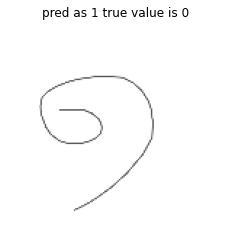

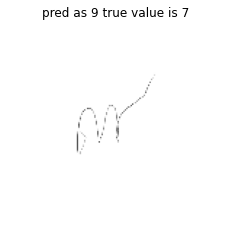

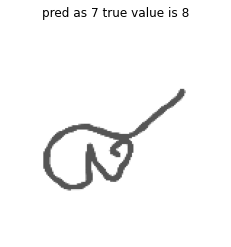

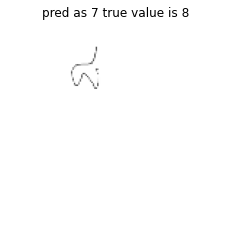

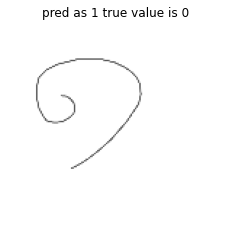

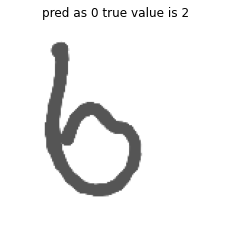

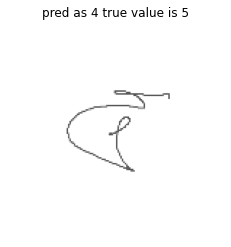

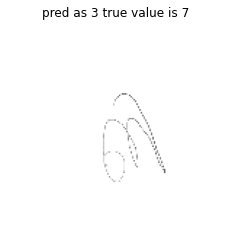

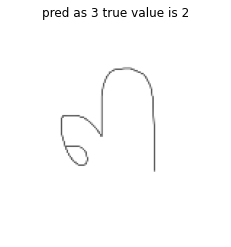

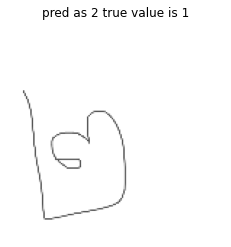

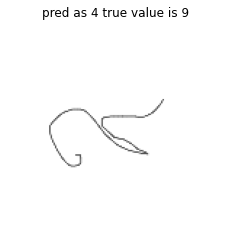

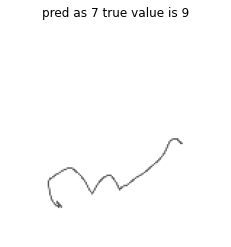

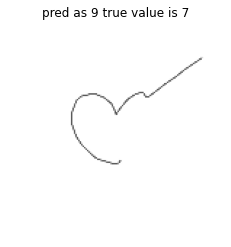

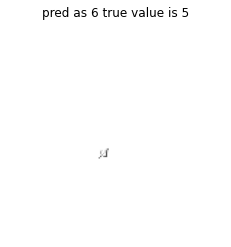

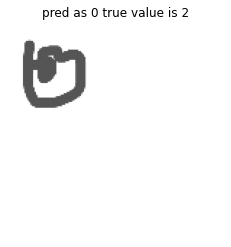

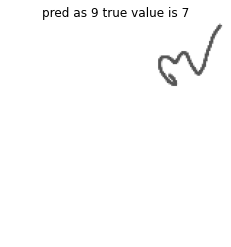

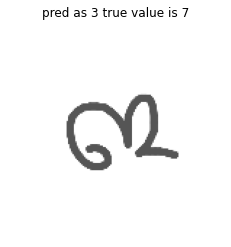

In [ ]:
x_false = x_test[y_pred_test != y_test]
y_true_false = y_test[y_pred_test != y_test]
y_pred_false = y_pred_test[y_pred_test != y_test]

for ind, x in enumerate(x_false):
    plt.imshow(x/255.)
    plt.title(f'pred as {y_pred_false[ind]} true value is {y_true_false[ind]}')
    plt.axis('Off')
    plt.show()

In [ ]:
tf.reduce_sum(tf.where(y_test == y_test,1.0,0.0)) - tf.reduce_sum(tf.where(y_pred_test == y_test,1.0,0.0))

<tf.Tensor: shape=(), dtype=float32, numpy=18.0>

## Transfer learning wo cropping

In [ ]:
keras.backend.clear_session()

prep_input = keras.applications.xception.preprocess_input
giant_ml = keras.applications.xception.Xception(include_top=False)

In [ ]:
inputs = keras.layers.Input(shape=(150, 150, 3))
outputs = giant_ml(prep_input(inputs))
outputs = keras.layers.GlobalAveragePooling2D()(outputs)
outputs = keras.layers.Dropout(0.3)(outputs)
outputs = keras.layers.Dense(10)(outputs)

my_giant_ml = keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
my_giant_ml.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

### Warm gradient first

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model_giant_ml', monitor='val_sparse_categorical_accuracy', save_best_only=True)

In [ ]:
giant_ml.trainable=False
my_giant_ml.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy()],
              optimizer='adam')

history = my_giant_ml.fit(new_trainset, epochs=20, validation_data=validset, callbacks=[early_cb, cp_cb])

Epoch 1/20
233/233 [==============================] - 52s 225ms/step - loss: 1.1553 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.7564 - val_sparse_categorical_accuracy: 0.7867
Epoch 2/20
233/233 [==============================] - 52s 224ms/step - loss: 0.8217 - sparse_categorical_accuracy: 0.7326 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.8400
Epoch 3/20
233/233 [==============================] - 36s 156ms/step - loss: 0.7215 - sparse_categorical_accuracy: 0.7684 - val_loss: 0.5538 - val_sparse_categorical_accuracy: 0.8279
Epoch 4/20
233/233 [==============================] - 52s 223ms/step - loss: 0.6606 - sparse_categorical_accuracy: 0.7903 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.8485
Epoch 5/20
233/233 [==============================] - 53s 226ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7884 - val_loss: 0.4780 - val_sparse_categorical_accuracy: 0.8679
Epoch 6/20
233/233 [==============================] - 37s 158ms/step - loss: 0.6138 -

In [ ]:
# one channel for cropping

trainset = image_dataset_from_directory('./tf-trainset', color_mode='grayscale', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='training')

validset = image_dataset_from_directory('./tf-trainset', color_mode='grayscale', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='validation')

# 3 channel
# trainset = image_dataset_from_directory('./tf-trainset', color_mode='rgb', image_size=(150,150), validation_split=0.1,
#                                     seed=107, subset='training')

# validset = image_dataset_from_directory('./tf-trainset', color_mode='rgb', image_size=(150,150), validation_split=0.1,
#                                     seed=107, subset='validation')

Found 8255 files belonging to 10 classes.
Using 7430 files for training.
Found 8255 files belonging to 10 classes.
Using 825 files for validation.


In [ ]:
def crop_img_tf(img):

    orig_shape = img.shape

    mask = img<255
    mask_x, mask_y = tf.reduce_any(mask, axis=0), tf.reduce_any(mask, axis=1)
    first_x_max, first_y_max = (tf.argmax(mask_x, axis=0) - 1)/orig_shape[0], (tf.argmax(mask_y, axis=0) - 1)/orig_shape[1]
    last_x_max = (orig_shape[0] - tf.argmax(tf.reverse(mask_x, axis=[0]), axis=0) + 1)/orig_shape[0]
    last_y_max = (orig_shape[1] - tf.argmax(tf.reverse(mask_y, axis=[0]), axis=0) + 1)/orig_shape[1]

    boxes = tf.cast(tf.concat([first_y_max, first_x_max, last_y_max, last_x_max], axis=-1), dtype=tf.float32)
    crop_size = (orig_shape[1], orig_shape[1])
    # crop and resize require 3 channel images
    return tf.squeeze(tf.image.crop_and_resize(tf.concat([img,img,img], axis=-1)[tf.newaxis], boxes[tf.newaxis], [0], crop_size))

In [ ]:
trainset = trainset.unbatch().map(lambda x, y: (crop_img_tf(x), y)).batch(32)
validset = validset.unbatch().map(lambda x, y: (crop_img_tf(x), y)).batch(32)

In [ ]:
def get_dataset_as_numpy(dataset):
    all_x, all_y = next(iter(dataset))

    for x, y in dataset.skip(1):
        all_x = tf.concat([all_x, x], axis=0)
        all_y = tf.concat([all_y, y], axis=0)

    return all_x, all_y

In [ ]:
x_train, y_train = get_dataset_as_numpy(trainset)
x_valid, y_valid = get_dataset_as_numpy(validset)

In [ ]:
new_trainset = traingen.flow(x_train, y_train)
# new_validset = traingen.flow(x_valid, y_valid)

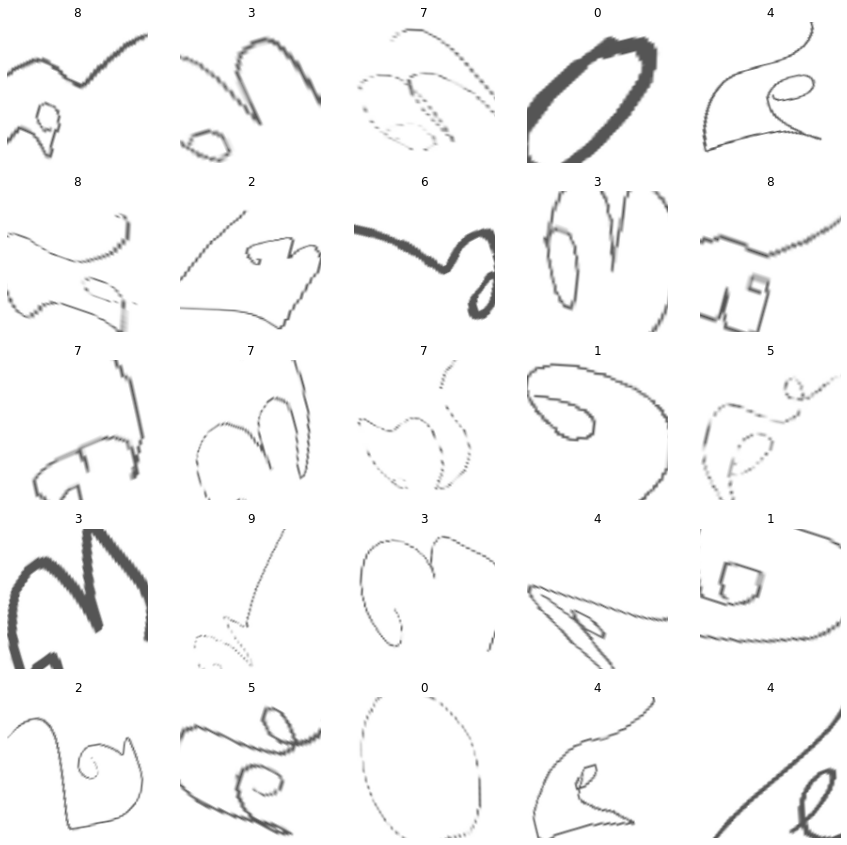

In [ ]:
num_show = 24
count = 0

imgs, labels = new_trainset[0]

plt.figure(figsize=(5*3,5*3))

for img, label in zip(imgs, labels):
    count += 1

    plt.subplot(5, 5, count)
    plt.imshow(tf.squeeze(img)/255.)
    plt.title(label)
    plt.axis('Off')

    if count > num_show:
        break

# Train on cropped Image. 
**Since, I have no drop list, so I will train on all of them!**

In [ ]:
# one channel for cropping

trainset = image_dataset_from_directory('./tf-trainset', color_mode='grayscale', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='training', batch_size=32).unbatch().batch(32, drop_remainder=True).cache().shuffle(buffer_size=1000).prefetch(2)

validset = image_dataset_from_directory('./tf-trainset', color_mode='grayscale', image_size=(150,150), validation_split=0.1,
                                    seed=107, subset='validation', batch_size=32).unbatch().batch(32, drop_remainder=True).cache().shuffle(buffer_size=1000).prefetch(2)

Found 8255 files belonging to 10 classes.
Using 7430 files for training.
Found 8255 files belonging to 10 classes.
Using 825 files for validation.


### custom crop layer

In [ ]:
def crop_img_tf(img):

    orig_shape = img.shape

    mask = img<255
    mask_x, mask_y = tf.reduce_any(mask, axis=1), tf.reduce_any(mask, axis=2)
    first_x_max, first_y_max = (tf.argmax(mask_x, axis=1) - 1)/orig_shape[1], (tf.argmax(mask_y, axis=1) - 1)/orig_shape[2]
    last_x_max = (orig_shape[1] - tf.argmax(tf.reverse(mask_x, axis=[1]), axis=1) + 1)/orig_shape[1]
    last_y_max = (orig_shape[2] - tf.argmax(tf.reverse(mask_y, axis=[1]), axis=1) + 1)/orig_shape[2]
    boxes = tf.cast(tf.concat([first_y_max, first_x_max, last_y_max, last_x_max], axis=-1), dtype=tf.float32)
    # dynamic loop
    box_inds=[i for i in range(32)]

    crop_size = (orig_shape[1], orig_shape[2])
    # crop and resize require 3 channel images
    return tf.image.crop_and_resize(tf.concat([img,img,img], axis=-1), boxes, box_inds, crop_size, extrapolation_value=255.)

def emphasize(img):
    mask = tf.where(img < 200, 0., 255.)
    
    return mask

def inv_black_white(img):
    mask = tf.where(255.-img < 10., 0., 255.)
    return mask

In [ ]:
crop_emphasize_model = keras.models.Sequential([
                                      keras.layers.Lambda(emphasize, batch_input_shape=(32, 150, 150, 1)),
                                      keras.layers.Lambda(crop_img_tf)
])

crop_model = keras.models.Sequential([
                                      keras.layers.Lambda(crop_img_tf, batch_input_shape=(32, 150, 150, 1))
])

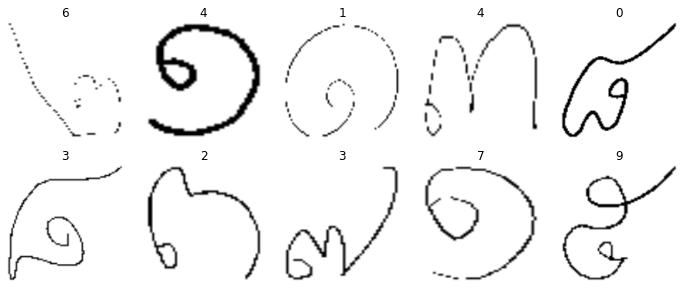

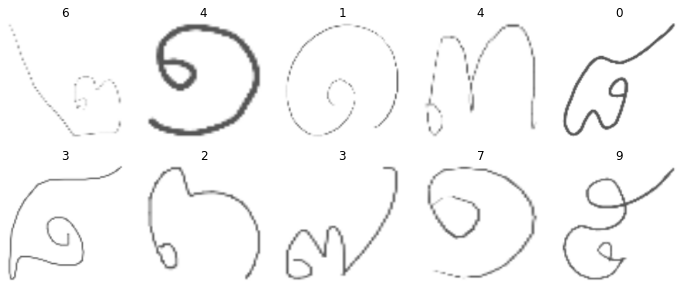

In [ ]:
# Plotting crop_emphasize and crop model
for train, label in trainset.take(1):
    x = tf.constant(train)
    temp = crop_emphasize_model(x)

    plt.figure(figsize=(10*1.2,4*1.2))
    for ind, x in enumerate(temp[:10]):
        plt.subplot(2, 5, ind+1)
        plt.imshow(tf.squeeze(x)/255)
        plt.title(y[ind].numpy())
        plt.axis('Off')    
    plt.show()

    plt.figure(figsize=(10*1.2,4*1.2))

    x = tf.constant(train)
    temp = crop_model(x)

    for ind, x in enumerate(temp[:10]):
        plt.subplot(2, 5, ind+1)
        plt.imshow(tf.squeeze(x)/255)
        plt.title(y[ind].numpy())
        plt.axis('Off')    

## toy model

In [ ]:
## create basic keras model
keras.backend.clear_session()

inputs = keras.layers.Input(shape=(150, 150, 1))
crop_outputs = crop_emphasize_model(inputs)
outputs = crop_outputs /255.
prep_input_model = keras.models.Model(inputs=inputs, outputs=outputs)

model = keras.Sequential([
    prep_input_model,
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.Conv2D(32, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.Conv2D(64, 4, activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10)
])

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
             optimizer='adam')

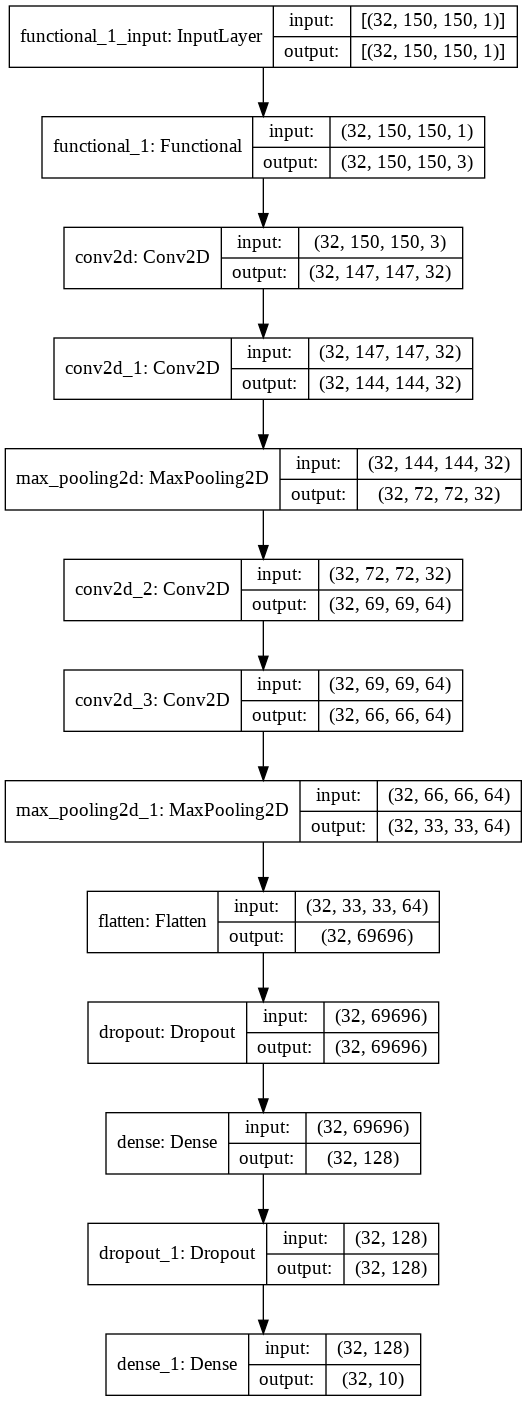

In [ ]:
keras.utils.plot_model(model, rankdir='TB', show_shapes='True')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (32, 150, 150, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 147, 147, 32)        1568      
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 144, 144, 32)        16416     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 72, 72, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 69, 69, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 66, 66, 64)          65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 33, 33, 64)          0

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model', monitor='val_acc', save_best_only=True)

In [ ]:
history = model.fit(trainset, epochs=20, validation_data=validset, callbacks=[cp_cb, early_cb])

Epoch 1/20
    232/Unknown - 35s 150ms/step - loss: 0.8208 - acc: 0.7272INFO:tensorflow:Assets written to: ./saved_model/assets
232/232 [==============================] - 41s 177ms/step - loss: 0.8208 - acc: 0.7272 - val_loss: 0.3642 - val_acc: 0.9025
Epoch 2/20
232/232 [==============================] - 40s 174ms/step - loss: 0.2901 - acc: 0.9131 - val_loss: 0.2875 - val_acc: 0.9137
Epoch 3/20
232/232 [==============================] - 41s 175ms/step - loss: 0.1835 - acc: 0.9423 - val_loss: 0.2211 - val_acc: 0.9350
Epoch 4/20
232/232 [==============================] - 38s 165ms/step - loss: 0.1234 - acc: 0.9591 - val_loss: 0.2557 - val_acc: 0.9262
Epoch 5/20
232/232 [==============================] - 41s 176ms/step - loss: 0.1033 - acc: 0.9647 - val_loss: 0.2800 - val_acc: 0.9388
Epoch 6/20
232/232 [==============================] - 38s 165ms/step - loss: 0.0796 - acc: 0.9727 - val_loss: 0.3296 - val_acc: 0.9175
Epoch 7/20
232/232 [==============================] - 38s 166ms/step - lo

## Toy model error analysis

In [ ]:
x_test, y_test = next(iter(validset.take(1)))
y_pred_test = tf.argmax(model.predict(x_test), axis=1, output_type=tf.int32)

for x, y in validset.skip(1):
    y_test = tf.concat([y_test, y], axis=0)
    y_pred = tf.argmax(model.predict(x), axis=1, output_type=tf.int32)
    y_pred_test = tf.concat([y_pred_test, y_pred], axis=0)
    x_test = tf.concat([x_test, x], axis=0)

In [ ]:
tf.reduce_mean(tf.where(y_pred_test == y_test,1.0,0.0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9375>

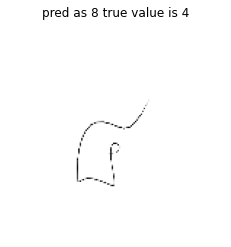

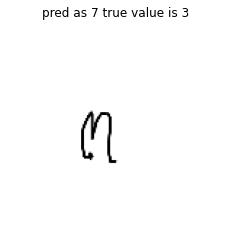

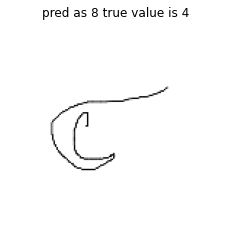

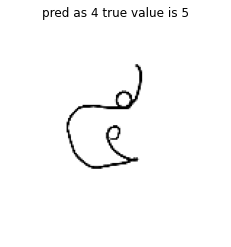

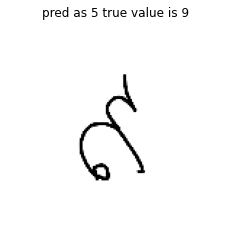

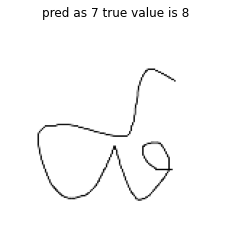

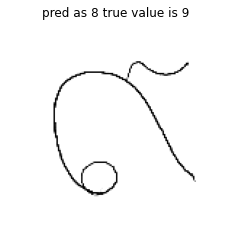

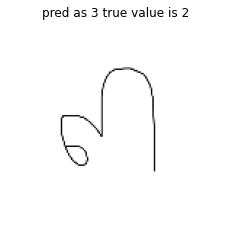

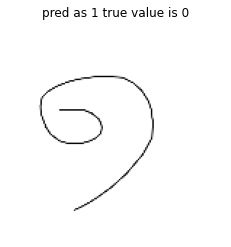

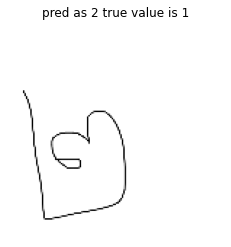

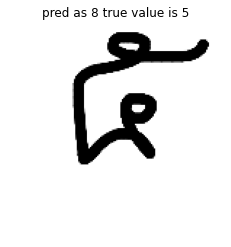

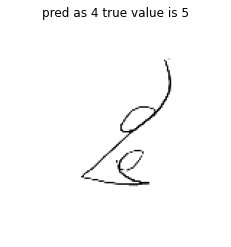

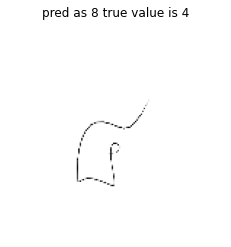

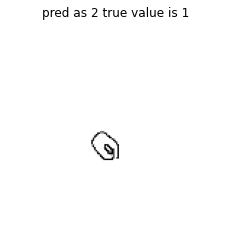

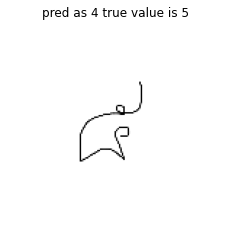

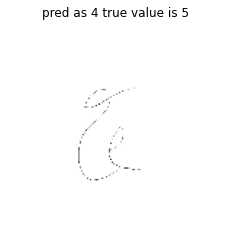

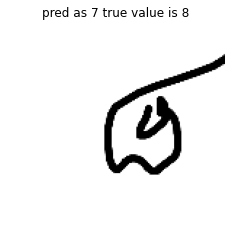

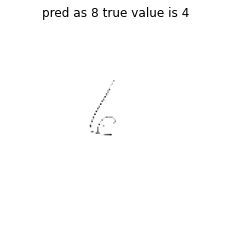

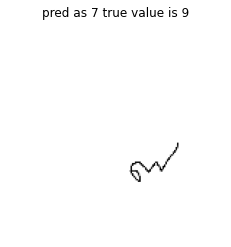

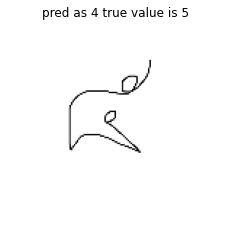

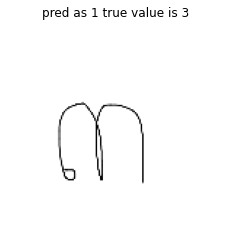

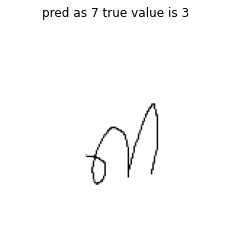

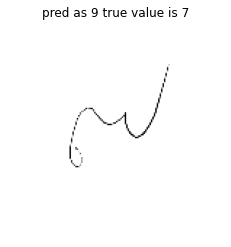

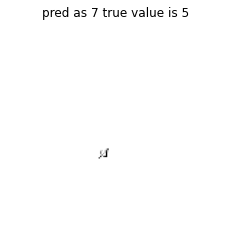

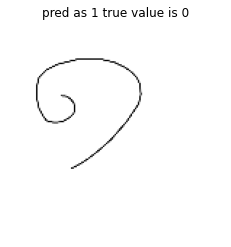

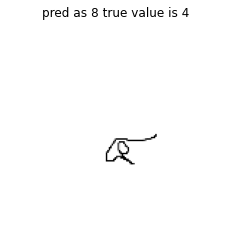

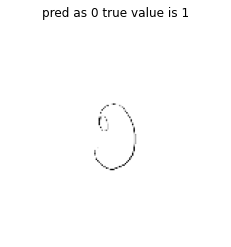

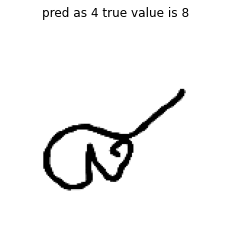

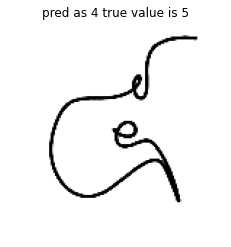

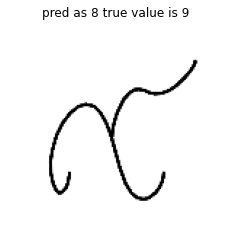

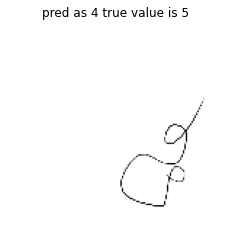

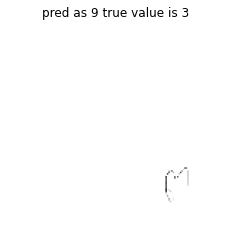

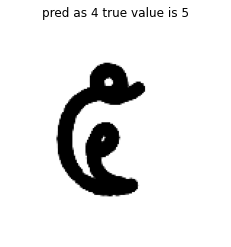

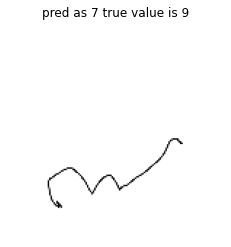

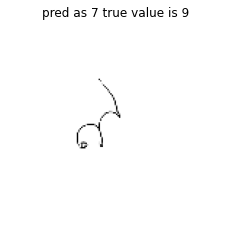

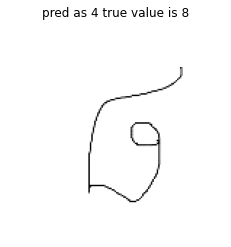

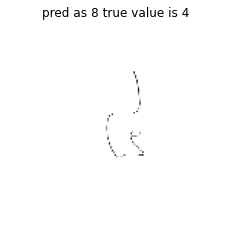

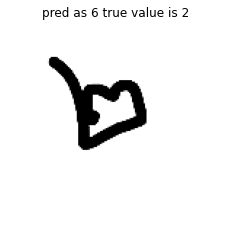

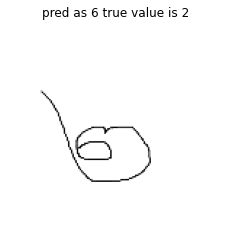

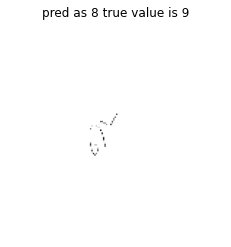

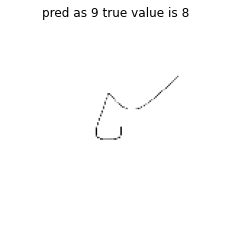

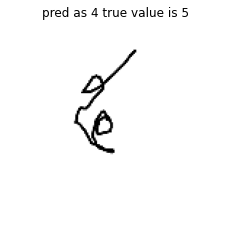

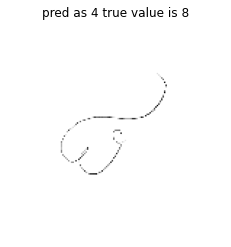

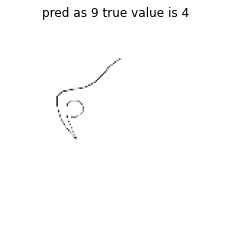

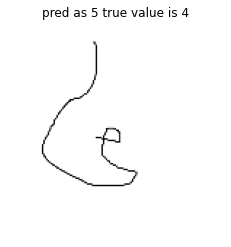

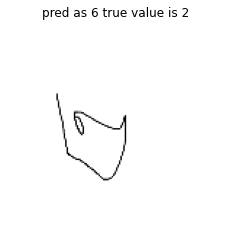

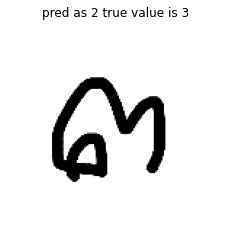

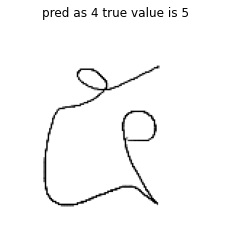

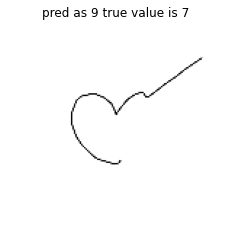

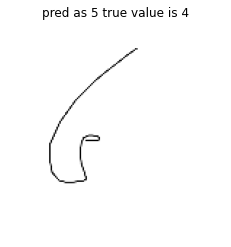

In [ ]:
x_false = x_test[y_pred_test != y_test]
y_true_false = y_test[y_pred_test != y_test]
y_pred_false = y_pred_test[y_pred_test != y_test]

for ind, x in enumerate(x_false):
    plt.imshow(tf.squeeze(x), cmap='gray')
    plt.title(f'pred as {y_pred_false[ind]} true value is {y_true_false[ind]}')
    plt.axis('Off')
    plt.show()

## Transfer learning

In [ ]:
keras.backend.clear_session()

prep_input = keras.applications.xception.preprocess_input
giant_ml = keras.applications.xception.Xception(include_top=False)

In [ ]:
inputs = keras.layers.Input(shape=(150, 150, 1))
crop_inputs = crop_model(inputs)
outputs = giant_ml(prep_input(crop_inputs))
outputs = keras.layers.GlobalAveragePooling2D()(outputs)
outputs = keras.layers.Dropout(0.3)(outputs)
outputs = keras.layers.Dense(10)(outputs)

my_giant_ml = keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
my_giant_ml.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 150, 150, 1)]       0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 150, 150, 3)         0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(32, 150, 150, 3)]       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(32, 150, 150, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (32, 2048)                0         
_________________________________________________________________
dropout (Dropout)            (32, 2048)               

### Warm gradient

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model_giant_ml', monitor='val_acc', save_best_only=True)
opt = keras.optimizers.SGD(lr=0.01)

In [ ]:
giant_ml.trainable=False
my_giant_ml.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
              optimizer=opt)

history = my_giant_ml.fit(trainset, epochs=20, validation_data=validset, callbacks=[early_cb, cp_cb])

Epoch 1/20
      1/Unknown - 0s 63us/step - loss: 0.4639 - acc: 0.8438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0086s vs `on_train_batch_end` time: 0.0308s). Check your callbacks.
    231/Unknown - 9s 37ms/step - loss: 0.4941 - acc: 0.8512WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0047s vs `on_test_batch_end` time: 0.0316s). Check your callbacks.
232/232 [==============================] - 10s 45ms/step - loss: 0.4941 - acc: 0.8512 - val_loss: 0.4401 - val_acc: 0.8875
Epoch 2/20
232/232 [==============================] - 25s 109ms/step - loss: 0.4817 - acc: 0.8555 - val_loss: 0.4333 - val_acc: 0.8900
Epoch 3/20
232/232 [==============================] - 26s 112ms/step - loss: 0.4781 - acc: 0.8579 - val_loss: 0.4269 - val_acc: 0.8913
Epoch 4/20
232/232 [==============================] - 26s 113ms/step - loss: 0.4619 - acc: 0.8611 - val_loss: 0.4223 - val_acc: 0.

### Train the whole giant model

In [ ]:
early_cb = keras.callbacks.EarlyStopping(monitor='val_acc', patience = 5, restore_best_weights=True)
cp_cb = keras.callbacks.ModelCheckpoint('./saved_model_giant_ml', monitor='val_acc', save_best_only=True)
opt = keras.optimizers.SGD(lr=0.0001)

In [ ]:
giant_ml.trainable=True
my_giant_ml.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')],
              optimizer=opt)

history = my_giant_ml.fit(trainset, epochs=50, validation_data=validset, callbacks=[early_cb, cp_cb])

Epoch 1/20
      2/Unknown - 0s 92ms/step - loss: 0.0347 - acc: 1.0000WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.1650s). Check your callbacks.
    232/Unknown - 42s 180ms/step - loss: 0.0842 - acc: 0.9879WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0059s vs `on_test_batch_end` time: 0.0307s). Check your callbacks.
INFO:tensorflow:Assets written to: ./saved_model_giant_ml/assets
232/232 [==============================] - 60s 259ms/step - loss: 0.0842 - acc: 0.9879 - val_loss: 0.2005 - val_acc: 0.9438
Epoch 2/20
232/232 [==============================] - 59s 254ms/step - loss: 0.0845 - acc: 0.9880 - val_loss: 0.2004 - val_acc: 0.9463
Epoch 3/20
232/232 [==============================] - 43s 184ms/step - loss: 0.0831 - acc: 0.9898 - val_loss: 0.1997 - val_acc: 0.9463
Epoch 4/20
232/232 [==============================] - 43s 184m

In [ ]:
my_giant_ml.evaluate(validset)

      1/Unknown - 0s 34ms/step - loss: 0.2162 - acc: 0.9688WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0081s vs `on_test_batch_end` time: 0.0339s). Check your callbacks.
25/25 [==============================] - 1s 38ms/step - loss: 0.2007 - acc: 0.9463


[0.20073387026786804, 0.9462500214576721]

## Error analysis

In [ ]:
x_test, y_test = next(iter(validset.take(1)))
y_pred_test = tf.argmax(my_giant_ml.predict(x_test), axis=1, output_type=tf.int32)

for x, y in validset.skip(1):
    y_test = tf.concat([y_test, y], axis=0)
    y_pred = tf.argmax(my_giant_ml.predict(x), axis=1, output_type=tf.int32)
    y_pred_test = tf.concat([y_pred_test, y_pred], axis=0)
    x_test = tf.concat([x_test, x], axis=0)

In [ ]:
tf.reduce_mean(tf.where(y_pred_test == y_test,1.0,0.0))

In [ ]:
x_false = x_test[y_pred_test != y_test]
y_true_false = y_test[y_pred_test != y_test]
y_pred_false = y_pred_test[y_pred_test != y_test]

for ind, x in enumerate(x_false):
    plt.imshow(tf.squeeze(x), cmap='gray')
    plt.title(f'pred as {y_pred_false[ind]} true value is {y_true_false[ind]}')
    plt.axis('Off')
    plt.show()